In [2]:
from pathlib import Path
from datetime import datetime
from typing import List, Tuple, Optional, Dict

import plotly.graph_objects as go
import plotly.io as pio
from tensorboard.backend.event_processing import event_accumulator

In [3]:
# ---------- helpers ----------
def _find_event_files(path: str) -> List[Path]:
    p = Path(path)
    if p.is_file():
        return [p]
    return sorted(
        p.rglob("events.out.tfevents*"),
        key=lambda f: f.stat().st_mtime,
        reverse=True,
    )


def _decimate_indices(n: int, max_points: int) -> List[int]:
    if n <= max_points:
        return list(range(n))
    stride = max(1, n // max_points)
    idx = list(range(0, n, stride))
    if idx[-1] != n - 1:
        idx.append(n - 1)
    return idx


def _ema(values: List[float], smoothing: float) -> List[float]:
    if smoothing <= 0:
        return values
    alpha = 1.0 - smoothing
    out = []
    for i, v in enumerate(values):
        out.append(v if i == 0 else alpha * v + (1 - alpha) * out[-1])
    return out


def _format_tdelta(seconds: float) -> str:
    sign = "-" if seconds < 0 else ""
    s = abs(seconds)
    d, r = divmod(s, 86400)
    h, r = divmod(r, 3600)
    m, s = divmod(r, 60)
    if d >= 1:
        return f"{sign}{int(d)}d {int(h):02d}:{int(m):02d}:{s:05.2f}"
    if h >= 1:
        return f"{sign}{int(h):02d}:{int(m):02d}:{s:05.2f}"
    if m >= 1:
        return f"{sign}{int(m):02d}:{s:05.2f}"
    return f"{sign}{(s if s >= 1 else s * 1000):.0f}{'s' if s >= 1 else ' ms'}"


def _load_scalar_series(
    path: str, tag: str
) -> Tuple[List[int], List[datetime], List[float], Path]:
    """
    Load (steps, times, values) for `tag` from the newest event file under `path`
    that contains the tag. Returns the event file used.
    """
    files = _find_event_files(path)
    if not files:
        raise FileNotFoundError(f"No TensorBoard event files found under: {path}")

    last_err = None
    for f in files:  # newest first
        try:
            acc = event_accumulator.EventAccumulator(
                str(f), size_guidance={"scalars": 0}
            )
            acc.Reload()
            if tag not in (acc.Tags().get("scalars", []) or []):
                continue
            scalars = sorted(acc.Scalars(tag), key=lambda s: (s.step, s.wall_time))
            if not scalars:
                continue
            steps = [s.step for s in scalars]
            times = [datetime.fromtimestamp(s.wall_time) for s in scalars]
            values = [float(s.value) for s in scalars]
            return steps, times, values, f
        except Exception as e:
            last_err = e
            continue

    raise ValueError(
        f"Tag '{tag}' not found in any event file under: {path}"
        + (f" (last error: {last_err})" if last_err else "")
    )


# ---------- main API ----------
def plot_tb_scalars(
    experiments: Dict[str, str],
    tag: str,
    xaxis: str = "step",  # "step" or "time"
    max_points: int = 5000,
    title: Optional[str] = None,
    include_plotlyjs: str = "cdn",
    save_html: str | None = None,
) -> None:
    """Experiments dict is a map from experiment readable name to path.

    This plots the same scalar across multiple runs for comparison.
    """
    assert xaxis in {"step", "time"}, "xaxis must be 'step' or 'time'"

    fig = go.Figure()
    plotted_any = False
    skipped = []

    for name, path in experiments.items():
        try:
            steps, times, values, src_file = _load_scalar_series(path, tag)
        except Exception as e:
            skipped.append((name, str(e)))
            continue

        # Δt relative to this run's first wall-time
        t0 = times[0]
        delta_str = [_format_tdelta((t - t0).total_seconds()) for t in times]

        x = steps if xaxis == "step" else times
        x_label = "Step" if xaxis == "step" else "Wall Time"

        idx = _decimate_indices(len(values), max_points)
        x_ds = [x[i] for i in idx]
        y_ds = [values[i] for i in idx]
        dt_ds = [delta_str[i] for i in idx]

        # Raw trace
        fig.add_trace(
            go.Scatter(
                x=x_ds,
                y=y_ds,
                mode="lines",
                name=name,
                legendgroup=name,
                opacity=0.35,
                customdata=dt_ds,
                hovertemplate=(
                    f"<br />{x_label}: %{{x}}<br>Δt: %{{customdata}}<br>value: %{{y}}"
                ),
            )
        )

        plotted_any = True

    if not plotted_any:
        raise RuntimeError(
            f"Nothing plotted. Either no event files found or tag '{tag}' missing in all runs."
            + (
                ""
                if not skipped
                else "\nSkipped:\n  - "
                + "\n  - ".join(f"{n}: {err}" for n, err in skipped)
            )
        )

    fig.update_layout(
        title=title or f"{tag}",
        xaxis_title=("Step" if xaxis == "step" else "Wall Time"),
        yaxis_title="Reward",
        template="plotly_white",
        hovermode="x unified",
        legend=dict(
            yanchor="bottom",
            y=0.01,
            xanchor="right",
            x=0.99,
            bgcolor="rgba(255,255,255,0.7)",  # light background
            bordercolor="black",
            borderwidth=1,
        ),
        margin=dict(l=60, r=20, t=50, b=50),
        height=600,
    )

    if save_html:
        # include_plotlyjs="inline" -> single, self-contained file (bigger)
        # include_plotlyjs="cdn"    -> smaller file, but needs internet
        pio.write_html(
            fig,
            file=save_html,
            full_html=False,
            include_plotlyjs=include_plotlyjs,
            auto_open=False,
        )
        print(f"Saved HTML to: {save_html} (include_plotlyjs={include_plotlyjs})")

    fig.show()

Saved HTML to: ../docs/assets/math_1k.html (include_plotlyjs=cdn)


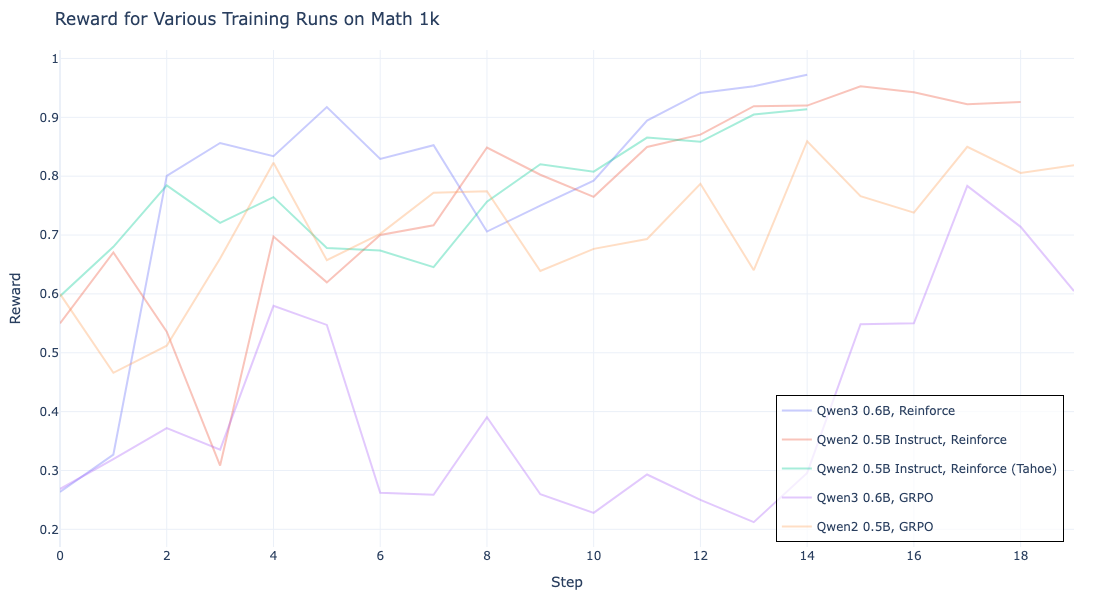

In [4]:
PREFIX = "/Users/kahnvex/projects/peralta/runs/"

plot_tb_scalars(
    {
        "Qwen3 0.6B, Reinforce": f"{PREFIX}2025-09-10_11-34-51/reinforce_qwen_qwen3-0.6b_math_1k",
        "Qwen2 0.5B Instruct, Reinforce": f"{PREFIX}2025-09-03_10-21-22/tensorboard",
        "Qwen2 0.5B Instruct, Reinforce (Tahoe)": f"{PREFIX}2025-08-29_08-16-56/tensorboard",
        "Qwen3 0.6B, GRPO": f"{PREFIX}2025-09-10_16-29-36/grpo_qwen_qwen3-0.6b_math_1k",
        "Qwen2 0.5B, GRPO": f"{PREFIX}2025-09-11_12-19-38/grpo_qwen_qwen2-0.5b-instruct_math_1k",
    },
    tag="all_rewards",
    xaxis="step",
    title="Reward for Various Training Runs on Math 1k",
    save_html="../docs/assets/math_1k.html",
)

Saved HTML to: ../docs/assets/math_10k.html (include_plotlyjs=cdn)


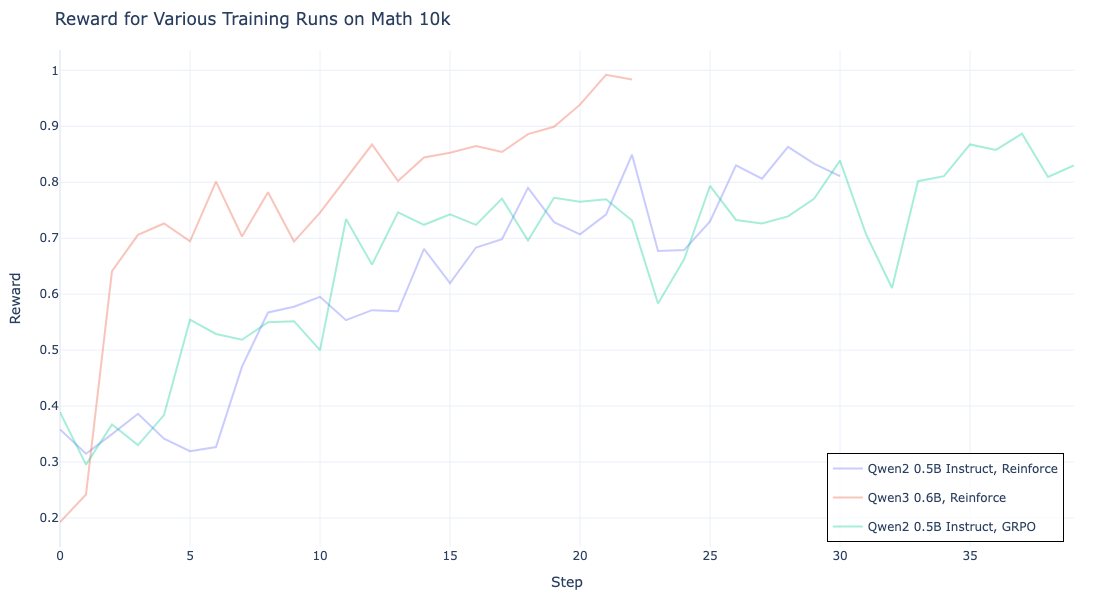

In [6]:
PREFIX = "/Users/kahnvex/projects/peralta/runs/"

plot_tb_scalars(
    {
        "Qwen2 0.5B Instruct, Reinforce": f"{PREFIX}2025-09-11_15-25-52/reinforce_qwen_qwen2-0.5b-instruct_math_10k",
        "Qwen3 0.6B, Reinforce": f"{PREFIX}2025-09-11_20-49-04/reinforce_qwen_qwen3-0.6b_math_10k",
        "Qwen2 0.5B Instruct, GRPO": f"{PREFIX}2025-09-12_13-33-17/grpo_qwen_qwen2-0.5b-instruct_math_10k",
    },
    tag="all_rewards",
    xaxis="step",
    title="Reward for Various Training Runs on Math 10k",
    save_html="../docs/assets/math_10k.html",
)